# Data Mining (Δ02): Exercise Set 1

<br>Name: Nefeli Eleftheria Sextou</br> 
<br> Student ID: 503</br> 
<br> E-mail: pcs00503@uoi.gr, nsekstou@cs.uoi.gr</br> 

### Imports

In [1]:
#general 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#k-fold cross validation 
from sklearn.model_selection import cross_val_score, KFold

#kNN
from sklearn.neighbors import KNeighborsClassifier

#Naive Bayes (Gaussian)
from sklearn.naive_bayes import GaussianNB

#SVMs: Linear and RBF kernels
from sklearn.svm import SVC

#Decision Trees 
from sklearn.tree import DecisionTreeClassifier


### Dataset Pre-processing 

In [2]:
data =pd.read_excel(r"C:\Users\Nefeli\Desktop\dm_msc\Dataset_503_2.xlsx")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   -0.6722201826725449  999 non-null    float64
 1   -1.17951587032472    999 non-null    float64
 2   2.375944140315288    999 non-null    float64
 3   -3.348327855995288   999 non-null    float64
 4   -3.143151081334082   999 non-null    float64
 5   2.867229908672977    999 non-null    float64
 6   0.8793876236415721   999 non-null    float64
 7   2.925024915939207    999 non-null    float64
 8   -4.130999189394323   999 non-null    float64
 9   2.0774065273352282   999 non-null    float64
 10  -4.167532649918552   999 non-null    float64
 11  -4.048917310966708   999 non-null    float64
 12  -1.4968274065174692  999 non-null    float64
 13  1.0                  999 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 109.4 KB
None


The original Excel file containing the dataset was an Excel 97-2003 Workbook. This caused an issue with reading the file, that is why it was saved as an Excel Workbook under a new name : <b>Dataset_503_2.xlsx</b>. 

It can immediately be observed that the data does not include specific names for each feature and the dataframe recongises the first value of each as a feature name. This is not desired. The problem may be mitgated by loading the file without a header so the first row is treated as data and not as column names. However, to make things more comprehensive, it is also easy to  generate column names based on their column index and then assign them to the dataframe's columns as their respective names.

In [3]:
# Load the xlsx file without the header
data = pd.read_excel(r"C:\Users\Nefeli\Desktop\dm_msc\Dataset_503_2.xlsx",header=None)
# Generate column names based on the column index
col_names = [f'f_{i}' for i in range(len(data.columns))]

# Assing the generated column names to the column names on the dataframe
data.columns = col_names

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_0     1000 non-null   float64
 1   f_1     1000 non-null   float64
 2   f_2     1000 non-null   float64
 3   f_3     1000 non-null   float64
 4   f_4     1000 non-null   float64
 5   f_5     1000 non-null   float64
 6   f_6     1000 non-null   float64
 7   f_7     1000 non-null   float64
 8   f_8     1000 non-null   float64
 9   f_9     1000 non-null   float64
 10  f_10    1000 non-null   float64
 11  f_11    1000 non-null   float64
 12  f_12    1000 non-null   float64
 13  f_13    1000 non-null   int64  
dtypes: float64(13), int64(1)
memory usage: 109.5 KB
None


Now, each column has a name and contains 1000 float64 values each, except 'f_13' which is the category column and is int64. There are no null entries.

Moving on to the next step of pre-processing, many classifiers are sensitive to differently scaled features and outliers. This is why it is important to apply Scaling to the data before moving forward to the application of different classification methods. The most common techniques to do this are Min-Max Normalization and Standardization. Both are sensitive to extreme outliers but Standardization tends to fare slightly better in those cases. In Min-Max Normalization, the data is usually brought to the \[0,1\] range while in Standardization, the mean of a feature becomes 0 while the standard deviation becomes 1. Before investigating Which one would suit the data best, because we do not have that many features, it is possible to visualize their distributions by obtaining their boxplots.

<Axes: >

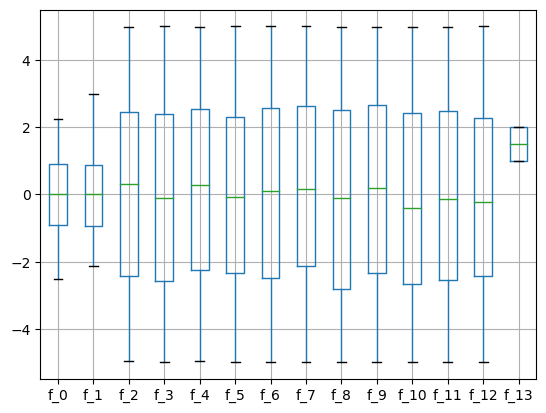

In [4]:
data.boxplot()

<br>From the boxplots, it is evident that there are no extreme outliers present. Moreover, many features seem to have similar distributions. Feature f_13 is the class/category variable so we may ingore it here.</br>

It is evident from the boxplots that the 'f_13' , the category column, contains the values 1 and 2. We may confirm this by checking what unique elements it contains.

In [5]:
np.unique(data['f_13'])

array([1, 2], dtype=int64)

It is common practice to encode the classes. Here, since there are only two categories and the problem is one of binary classification, we can use LabelEncoder to convert the different categories (from whatever form they are in) into integer values from 0 to (number of classes - 1). Here that means converting 1 and 2 to 0 and 1 respectively. SInce the labels already have the same ordonal relationship and the are integers instead of nominal data, it may be ok to leave them be in their original form since SciKit classifiers can usually handle them with no issue. However, it is generally good practive to apply this as a formal precautionary step that ensures that no unwanted behaviors occur down the line. 

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['f_13']=encoder.fit_transform(data['f_13'])

In [7]:
zeros = data['f_13'].value_counts()[0]
ones = data['f_13'].value_counts()[0]
print("Number of class 0 instances = {}    Number of class 1 instances = {} ".format(zeros, ones)) 

Number of class 0 instances = 500    Number of class 1 instances = 500 


Counting the instances of each class, we may conclude the dataset is perfectly balanced with 500 instances of each class.

#### Separate Feature Data and Target Variable

In [8]:
X = data.iloc[:, :13].copy() # feature data
y = data['f_13'].copy() #target variable - class/category column

#### Scaling 

<br>With regard to the scaling techniques we can use, we may choose either. However, it must be noted that all features have both positive and negative values. That is why SciKit Learn's MaxAbsScaler may be a good choice, given it will scale all features to \[-1,1\] since both positive and negative values are present. It is similar to the Min-Max Normalization Scaler (MinMaxScaler) and is subject to the same shortcomings. </br>

- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html
- https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-max-abs-scaler-section

In [9]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

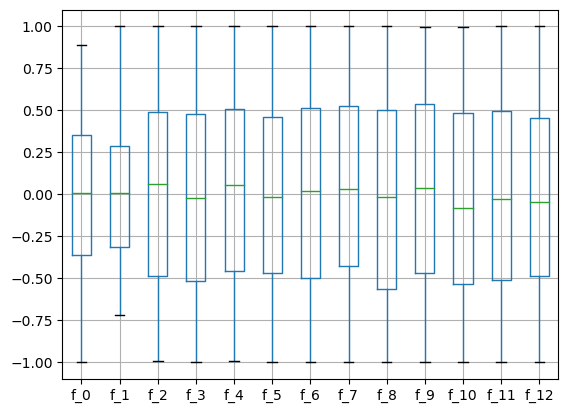

In [10]:
X_scaled_df = pd.DataFrame(X_scaled, columns=data.columns[:13])
X_scaled_df.boxplot()
plt.show()

### Shuffle the Dataset 

The data is shuffled once with the use of shuffle() which performs random permutations of the rows of the dataset provided as input. In the 10-fold Cross Validation split through the use of KFold(), the data is also shuffled before splitting into batches. This is done to remove any biases introduced by any specific order the data may have in its original form. Here, in the original form, the data had all rows of one class sequential to each other, followed by all the samples of the other class. This is bound to cause issues with fitting and generalization if left unremedied.

- https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html

In [11]:
from sklearn.utils import shuffle

# shuffle the data rows
X_shuffled, y_shuffled = shuffle(X_scaled, y, random_state=42)

## How 10-fold Cross-Validation Is Implemented 

For each classifier tested here, 10-fold Cross-Validation is implemented by the use of sklearn's <b>KFold</b> and <b>cross_val_score</b> functions. <b>KFold</b> splits the data into the 10 folds and with the setting of shuffle set to True, also shuffles them before splitting into batches. The result contains the indices of the respective folds, not the full data. <b>cross_val_score</b> takes the classifier and data as input as well as the KFold object, which specifies the cross validation strategy. The scoring setting is set to 'accuracy', however this could have been ommited since the default setting is in fact the accuracy metric.

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [12]:
kf = KFold(n_splits=10, shuffle=True, random_state=42) #seed is set to 42 for reproducibility

This split only needs to be done once here, since we are comparing different classifiers under the same conditions.

## kNN 

A kNN model is evaluated using 10-fold cross validation for values of k in range of \[1,9\].

10-fold Cross Validation is performed for each k. The mean of the accuracy scores that result from each such iteration is preserved and later accessed to find the best parameterization. The best choice of k corresponds to the k that results in the highest mean acccuracy score. 

- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [13]:
# k values to be tested 
k_vals= list(range(1, 9))  #[1,9]

# init accuracy result lists 
mean_acc = []

# 10-fold cross-validation for each k
for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn,X_shuffled, y_shuffled, cv=kf,scoring='accuracy') #seed is set to 42 for reproducibility
    mean_acc.append(np.mean(scores))

best_idx = mean_acc.index(np.max(mean_acc)) #get the index of the best (max) accuracy score mean (from 10-fold)
best_k = k_vals[best_idx]
    

print(" ")
print("Best k = {} for Mean Accuracy = {} ".format(best_k, mean_acc[best_idx]))

 
Best k = 7 for Mean Accuracy = 0.626 


A plot of the mean accuracy scores for each k helps us visualize the classifier's behavior as we change the hyperparameter setting.

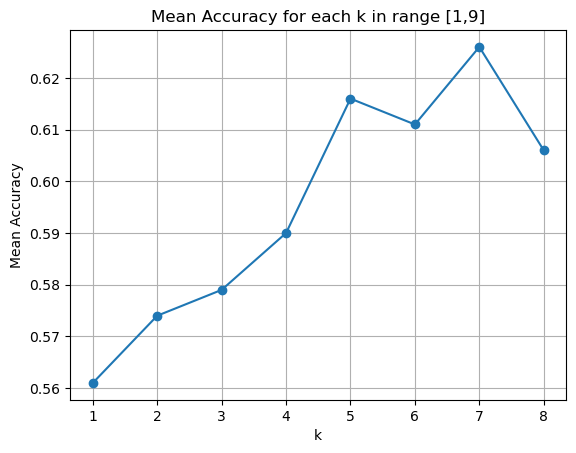

In [14]:
plt.plot(k_vals,mean_acc, marker='o', linestyle='-')
plt.xlabel('k')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy for each k in range [1,9]')
plt.grid(True)
plt.show()

The best choice of k is 7 since it results in the highest mean accuracy score of 0.626. From the plot we may observe an increase in accuracy until it starts what resembles the start of an oscillation which is indicative of overfitting.  

## Naive Bayes (Gaussian)  

Naive Bayes assuming a Normal distribution is implemented via sklearn's <b>GaussianNB()</b> classifier. <b>cross_val_score </b> fits for all 10-fold CV cases and returns the accuracy scores.

- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [15]:
gnb = GaussianNB()
scores = cross_val_score(gnb, X_shuffled, y_shuffled, cv=kf,scoring='accuracy') #seed is set to 42 for reproducibility

print("Accuracy for each case in the k-fold procedure: ",scores)

print("Mean Accuracy: ",np.mean(scores))
print("Median Accuracy: ",np.median(scores))
print("Accuracy St.Dev: ",np.std(scores))

Accuracy for each case in the k-fold procedure:  [0.42 0.53 0.49 0.45 0.5  0.42 0.51 0.48 0.55 0.48]
Mean Accuracy:  0.483
Median Accuracy:  0.485
Accuracy St.Dev:  0.041000000000000016


The mean accuracy is too low, this classifier is unable to generalize well.

## SVMs 

SVM's are implemented via sklearn's <b>SVC</b>. For a linear kernel , the <i>kernel</i> parameter must be set to 'linear'. No other parameters are necessary for this case. For an RBF kernel, the <i>kernel</i> parameter must be set to 'rbf'. The parameter we are interested in tuning is the <i>gamma</i> parameter which is equal to 1 / (n_features * X.var()). X.var includes the information of the kernel radius since it is the radius^2.

A bigger gamma value corresponds to a smaller radius value and a steeper kernel and therfore a smaller influence of individual data points on the decesion boundary and more detailed separation. Very large gamma values (with respect to the problem) may lead to overfitting since the model may potentially capture noise.

A smaller gamma value corresponds to a bigger radius value, a smoother kernel and therfore a greater influence of individual data points on the decesion boundary and less detailed separation. Very small gamma values (with respect to the problem) may lead to underfitting since the model may potentially fail to capture the underlying structure of the data.

- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
- https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf


### Linear Kernel 

In [16]:
svc = SVC(kernel='linear')
scores = cross_val_score(svc,X_shuffled, y_shuffled, cv=kf,scoring='accuracy') #seed is set to 42 for reproducibility

print("Mean Accuracy: ",np.mean(scores))
print("Median Accuracy: ",np.median(scores))
print("Accuracy St.Dev: ",np.std(scores))

Mean Accuracy:  0.48600000000000004
Median Accuracy:  0.495
Accuracy St.Dev:  0.043863424398922636


The linear kernel SVM does not generalize well on this problem.

### RBF Kernel

According to sklearn's documentation, producing a logarithmic grid from 10^(-3) to 10^(3) is considered a good way to find a range of values to test for the <i>gamma</i> parameter. 20 values are tested.

In [17]:
gamma_vals = np.logspace(-3, 3, num=20)
print("gamma values: ",gamma_vals)

gamma values:  [1.00000000e-03 2.06913808e-03 4.28133240e-03 8.85866790e-03
 1.83298071e-02 3.79269019e-02 7.84759970e-02 1.62377674e-01
 3.35981829e-01 6.95192796e-01 1.43844989e+00 2.97635144e+00
 6.15848211e+00 1.27427499e+01 2.63665090e+01 5.45559478e+01
 1.12883789e+02 2.33572147e+02 4.83293024e+02 1.00000000e+03]


In [18]:
# Initialize accuracy result lists 
mean_acc = []

for g in gamma_vals:
    svc = SVC(kernel='rbf',gamma=g)
    scores = cross_val_score(svc,X_shuffled, y_shuffled, cv=kf,scoring='accuracy') #seed is set to 42 for reproducibility
    mean_acc.append(np.mean(scores))
    
best_idx = mean_acc.index(np.max(mean_acc)) #get the index of the best (max) accuracy score mean (from 10-fold)
best_gamma = gamma_vals[best_idx]
    

print(" ")
print("Best gamma = {} for Mean Accuracy = {} ".format(best_gamma, mean_acc[best_idx]))    
    


 
Best gamma = 0.3359818286283781 for Mean Accuracy = 0.718 


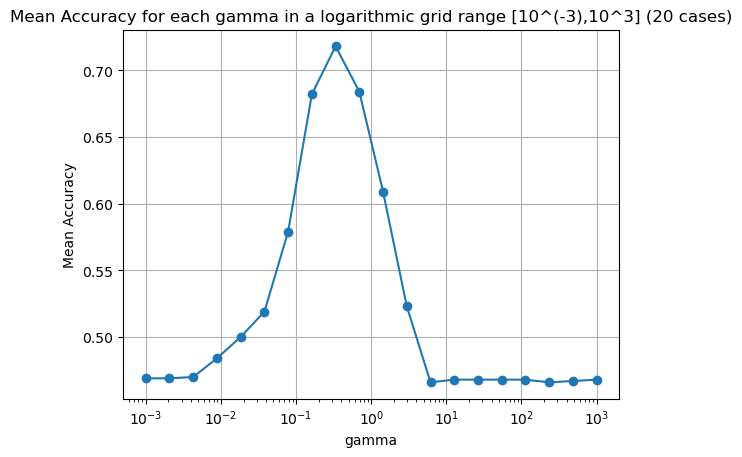

In [19]:
plt.plot(gamma_vals, mean_acc, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('gamma')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy for each gamma in a logarithmic grid range [10^(-3),10^3] (20 cases)')
plt.grid(True)
plt.show()

The best choice of gamma out of the tested range is 0.3359818286283781 for an Accuracy of 0.718. Observing the plot of the mean accuracy for each gamma tested, the flat areas indicate areas where the model seems to underfit the data. There exist areas where the accuracy increases and decreases for different gamma values, and a clear best point for the best gamma choice.

## Decision Trees 

Decision tree classification is implemented via sklearn's <b>DecesionTreeClassifier</b>. The hyperparameters to be tuned are the maximum leaf nodes <i>max_leaf_nodes</i> and the minimum samples per leaf <i>min_samples_leaf</i>. 10 fold cross validation is applied for each hyperparameter pair.

The <i>max_leaf_nodes</i> hyperparameter controls the maximum number of leaf nodes a decesion tree may have. A larger value leads to a more complex tree with more refined splits. It may lead to overfitting, particularly in cases with noisy data.

The <i>min_samples_leaf</i> hyperparameter controls the minimum number of samples required to exist in a leaf node. An increase of this parameter may lead to tree that is less specific and this may potentially result in underfitting for large values.

The goal of the hyperparameter tuning here is to find a pair of those hyperparameters that optimize the trade-off between model complexity and the resulting generalization ability. 

- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [20]:
# init accuracy result lists 
mean_acc = []
hparam_pairs= []
# max nodes and min samples per leaf hyperparams 
max_nodes = [5,10,25,50,100,250,500,1000]  #number of nodes
min_samples_per_leaf = [1,5,10,20,50,100]  #leaf size

for n in max_nodes:
    for m in min_samples_per_leaf:
        dt = DecisionTreeClassifier(max_leaf_nodes=n, min_samples_leaf=m, random_state=42)
        scores = cross_val_score(dt, X_shuffled, y_shuffled, cv=kf,scoring='accuracy')  # Seed is set to 42 for reproducibility
        mean_acc.append(np.mean(scores))
        hparam_pairs.append((n, m))

best_idx = mean_acc.index(np.max(mean_acc)) #get the index of the best (max) accuracy score mean (from 10-fold)
best_pair = hparam_pairs[best_idx]
    

print(" ")
print("Best hyperparameter pair = {} for Mean Accuracy = {} ".format(best_pair, mean_acc[best_idx]))            
        

 
Best hyperparameter pair = (50, 1) for Mean Accuracy = 0.682 


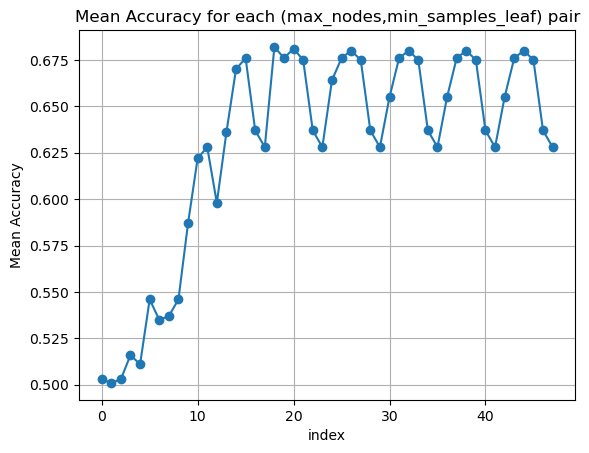

In [21]:
plt.plot([x for x in range(len(mean_acc))],mean_acc, marker='o', linestyle='-')
plt.xlabel('index')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy for each (max_nodes,min_samples_leaf) pair')
plt.grid(True)
plt.show()

The best hyperparameter pair is (50,1), this corresponds to at most 50 leaf nodes and a leaf size of at least 1. The resulting mean accuracy for this pair is 0.68. The mean accuracy plot for all tested pairs illustrates that the accuracy increases until oscillations are observed. These oscillations indicate overfitting.

## Choosing the Best Out of All Tuned and Evaluated Classifiers

Having chosen the best hyperparameters wherever necessary, we have the following:

- kNN for k = 7 with Mean Accuracy = 0.626 
- Naive Bayes (Gaussian) with Mean Accuracy = 0.483 
- SVM (Linear Kernel) with Mean Accuracy =  0.48600000000000004 
- SVM (RBF Kernel) for gamma = 0.3359818286283781 with Mean Accuracy = 0.718 
- Decision Tree for  (max_leaf_nodes,min_samples_leaf) = (50,1) with Mean Accuracy = 0.682  

Based on Mean Accuracy alone, the best classifier for the given dataset is the RBF Kernel SVM for gamma = 0.3359818286283781 with Mean Accuracy = 0.718. Accuracy of 0.7 and over is generally considered mediocre to decent, depending on the problem's needs.  